# Vision Transformer (ViT)

El Vision Transformer (ViT), propuesto por Dosovitskiy et al. (2020), utiliza una arquitectura basada en Transformers para tareas de visión por computadora. A diferencia de las CNN, el ViT aplica **Multi-Head Self-Attention (MHSA)** para modelar relaciones globales entre partes de la imagen.

## Arquitectura

El ViT divide las imágenes en **patches** y las convierte en una secuencia de vectores de características (embeddings), que luego se procesan mediante capas Transformer. A continuación, se aplica el mecanismo de self-attention para modelar las relaciones entre estos patches.

- **Embeddings**: Cada parche se aplana y se proyecta en un espacio de mayor dimensión.
- **Positional Encoding**: Se agrega un embebido posicional para cada parche, permitiendo que el modelo capture las posiciones espaciales.
---
## ¿Cómo funciona el Self-Attention en ViT?

Cada uno de los parches se considera un token similar a las palabras en el procesamiento del lenguaje natural (NLP).
En el mecanismo de Self-Attention, cada uno de estos tokens (parches) puede interactuar con los demás tokens. Para hacerlo, el modelo calcula tres vectores para cada token:

- **Query:** Representa qué está buscando el token.

- **Key:** Representa una descripción de los demás tokens.

- **Value:** Es la información que tiene cada token y que podría ser relevante para otros tokens.

Luego, se calculan las similitudes entre el *Query* de un token y el *Key* de todos los demás tokens, lo que genera una "puntuación de atención". Esta puntuación determina cuánta atención debe prestar un token a otros. El valor *Value* de cada token se pondera según esta puntuación, lo que permite que un token integre información de todo el resto de la imagen.

Este mecanismo es lo que permite que cada token (parche) en una imagen entienda no solo lo que está ocurriendo en su área local, sino también pueda considerar qué está sucediendo en otras partes de la imagen.

La fórmula utilizada para calcular la atención es:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Donde:
- **$Q$ (queries)**, **$K$ (keys)**, y **$V$ (values)** son las proyecciones lineales de los embeddings de los patches.
- **$d_k$** es la dimensionalidad de las proyecciones, usada para escalar el producto punto y estabilizar el entrenamiento.

Este proceso se aplica en múltiples cabezas, lo que permite al modelo aprender distintas representaciones.

El mecanismo de self-attention utiliza las proyecciones:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Donde $X$ es el input y $W_Q$, $W_K$, y $W_V$ son matrices de pesos aprendidos.

Después de aplicar el mecanismo de Self-Attention, los tokens se actualizan, ya que ahora tienen información de los demás tokens. Este proceso se repite varias veces en distintas capas de atención, profundizando la interacción entre los parches.

Salida Final: Después de aplicar múltiples capas de Self-Attention, el modelo agrupa los tokens procesados para predecir la clase de la imagen o realizar otras tareas de visión.


![Vision Transformer](vit_gif.gif)

*Crédito: [lucidrains](https://github.com/lucidrains/vit-pytorch)*


## Tareas:

1. **Implementar la arquitectura de un Vision Transformer**

2. **Ingresar y ajustar los parametros del modelo***

3. **Probar diferentes técnicas de data augmentation**

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer, EarlyStopping



device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches


class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x + self.pos_embedding

# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(device,img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional

num_patches = (img_size // patch_size) ** 2
try:
    positional_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
    pos_embeddings = positional_encoding(patches)

except Exception as e:
    print(f"Revise la existencia de la función PositionalEncodingLearned. Se produjo error durante la compilación: \n {e}.")


Dispositivo:  cuda
Torch version:  2.6.0+cu124


# Transformer Encoder

In [2]:
class TransformerEncoder(nn.Module):
    def __init__(
        self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1, batch_first=True
    ):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            bias=False,
            batch_first=batch_first,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

    def forward(self, x):
        return self.transformer_encoder(x)

# Vision Transformer
Model
>
```ViT-Base ViT-Large ViT-Huge
    Layers Hidden size D 12 768
    24 1024 32 1280
    MLP size Heads
    Params
    3072 12 86M 4096 16 307M 5120 16 632M
```


In [3]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_channels: int = 3,
        embed_dim: int = 768,
        num_layers: int = 12,
        num_heads: int = 12,
        ff_dim: int = 3072,
        num_classes: int = 1000,
        dropout: float = 0.1,
        batch_first: bool = True,
    ):
        super(VisionTransformer, self).__init__()

        self.num_patches = (img_size // patch_size) ** 2

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = PositionalEncodingLearned(self.num_patches + 1, embed_dim)

        self.transformer = TransformerEncoder(
            embed_dim, num_heads, ff_dim, num_layers, dropout, batch_first
        )

        self.mlp_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x shape: (B, C, H, W)
        B = x.size(0)
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1 + num_patches, embed_dim)

        x = self.pos_embedding(x)  # (B, 1 + num_patches, embed_dim) due to broadcasting

        x = self.transformer(x)  # (B, 1 + num_patches, embed_dim)

        cls_out = x[:, 0]  # use just CLS token for classification
        return self.mlp_head(cls_out) # (B, num_classes)

# CIFAR10

In [11]:
# # Augmentation pipeline 1
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         [0.49139968, 0.48215841, 0.44653091],
#         [0.24703223, 0.24348513, 0.26158784]
#     ),
# ])

# Augmentation pipeline 2
transform_train = transforms.Compose([
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Enhance color variation
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3)),         # Mimic occlusion
    transforms.Normalize(
        mean=[0.49139968, 0.48215841, 0.44653091],
        std=[0.24703223, 0.24348513, 0.26158784]
    ),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
images, labels = next(iter(train_loader))

print(f"Image shape: {images.shape[1:]}\n")

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Image shape: torch.Size([3, 32, 32])

Number of training images: 50000
Number of test images: 10000


In [14]:
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


## **Entrenamiento**

In [16]:
'''
A continuacion ingrese los parametros del modelo

'''

model = VisionTransformer(
    img_size=32,
    patch_size=4,
    in_channels=3,
    embed_dim=192,
    num_heads=6,
    ff_dim=384,
    num_layers=6,
    dropout=0.1,
    batch_first=True
).to(device)


# print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

model = model.to(device)

try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

In [17]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))

Número de parámetros: 1.99 millones


In [18]:
trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)

early_stopping = EarlyStopping(
    patience=5,
    min_delta=1e-3,
    restore_best_weights=True
)

In [24]:
num_epochs = 50

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss = trainer.train_model(use_amp=True)
    val_loss = trainer.eval_model()

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

    if early_stopping(trainer.model, val_loss):
        break

    #scheduler.step()

Epoch 1/50


100%|██████████| 313/313 [00:04<00:00, 67.98it/s]


Train Loss: 0.7561
Validation Loss: 0.7934
Epoch 2/50


100%|██████████| 313/313 [00:03<00:00, 83.99it/s]


Train Loss: 0.7436
Validation Loss: 0.8014
Epoch 3/50


100%|██████████| 313/313 [00:03<00:00, 83.92it/s]


Train Loss: 0.7338
Validation Loss: 0.7784
Epoch 4/50


100%|██████████| 313/313 [00:04<00:00, 71.88it/s]


Train Loss: 0.7293
Validation Loss: 0.7611
Epoch 5/50


100%|██████████| 313/313 [00:03<00:00, 85.10it/s]


Train Loss: 0.7204
Validation Loss: 0.7483
Epoch 6/50


100%|██████████| 313/313 [00:03<00:00, 84.09it/s]


Train Loss: 0.7075
Validation Loss: 0.7598
Epoch 7/50


100%|██████████| 313/313 [00:04<00:00, 72.36it/s]


Train Loss: 0.7056
Validation Loss: 0.7728
Epoch 8/50


100%|██████████| 313/313 [00:03<00:00, 80.43it/s]


Train Loss: 0.6967
Validation Loss: 0.7563
Epoch 9/50


100%|██████████| 313/313 [00:03<00:00, 84.96it/s]


Train Loss: 0.6836
Validation Loss: 0.7501
Epoch 10/50


100%|██████████| 313/313 [00:03<00:00, 84.65it/s]


Train Loss: 0.6870
Validation Loss: 0.7229
Epoch 11/50


100%|██████████| 313/313 [00:04<00:00, 69.96it/s]


Train Loss: 0.6715
Validation Loss: 0.7389
Epoch 12/50


100%|██████████| 313/313 [00:03<00:00, 81.89it/s]


Train Loss: 0.6655
Validation Loss: 0.7461
Epoch 13/50


100%|██████████| 313/313 [00:03<00:00, 83.72it/s]


Train Loss: 0.6635
Validation Loss: 0.7220
Epoch 14/50


100%|██████████| 313/313 [00:04<00:00, 68.96it/s]


Train Loss: 0.6584
Validation Loss: 0.7319
Epoch 15/50


100%|██████████| 313/313 [00:03<00:00, 83.68it/s]

Train Loss: 0.6494
Validation Loss: 0.7412


In [25]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict() if scheduler else None
}

torch.save(checkpoint, 'checkpoint.pth')

In [26]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, precision, recall, f1

# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)


  0%|          | 0/313 [00:00<?, ?it/s]

In [28]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

Accuracy: 0.7519
Precision: 0.7502
Recall: 0.7519
F1 score: 0.7502


## **Resultados**

**Experimento 1**

Arquitectura simple con técnicas de data augmentation básicas: horizontal flip y random sized crop.

In [ ]:
experiment_01 = {
    "augmentation_pipeline": 1,
    "patch_size": 8,
    "embed_dim": 128,
    "num_heads": 4,
    "ff_dim": 256,
    "num_layers": 4,
    "dropout": 0.1,
    "num params (M)": 0.68,
    "epochs": 50,
    "results": {
        "val_loss": 0.9543,
        "accuracy": 0.67,
        "precision": 0.67,
        "recall": 0.67,
        "f1_score": 0.66
    }
}

Si bien el entrenamiento no llegó a detenerse debido al early stopping, sino que entrenó durante las 50 épocas predefinidas, aún así podemos obtener conclusiones parciales. El modelo aprende, tal como puede verse en el descenso del costo de entrenamiento a través de las diferentes épocas y no sobre-ajusta en esa cantidad de épocas.

Vamos a probar un nuevo entrenamiento modificando los parámetros para aumentar el tamaño de la red. Vamos a conservar el valor de dropout en 0.1, ya que el modelo no muestra signos de sobre-ajuste.

**Experimento 2**

Incremento en la complejidad de la arquitectura e introducción de técnicas de data augmentation más avanzadas: color jitter y random erasing.

In [ ]:
experiment_02 = {
    "augmentation_pipeline": 1,
    "patch_size": 4,             # Finer spatial resolution → 64 patches instead of 16
    "embed_dim": 192,            # Slightly higher embedding dim = more capacity
    "num_heads": 6,              # Must divide embed_dim (192 / 6 = 32)
    "ff_dim": 384,               # Keep ~2× the embed_dim
    "num_layers": 6,             # A bit deeper — can help with small datasets
    "dropout": 0.1,              # Keep stable
    "num params (M)": 1.99,
    "epochs": 65,
    "results": {
        "accuracy": 0.7519,
        "precision": 0.7502,
        "recall": 0.7519,
        "f1_score": 0.7502
    }
}

Los resultados obtenidos en el segundo experimento son considerablemente mejores a los obtenidos en el primer experimento. El entrenamiento se detuvo debido al early stopping utilizado, por lo que podríamos considerarlo finalizado.

Indudablemente el incremento en la complejidad de la arquitectura, asi como la utilización de técnicas de data augmentation mas avanzadas permitio alcanzar resultados mucho mejores en el dataset de CIFAR10.

  0%|          | 0/313 [00:00<?, ?it/s]

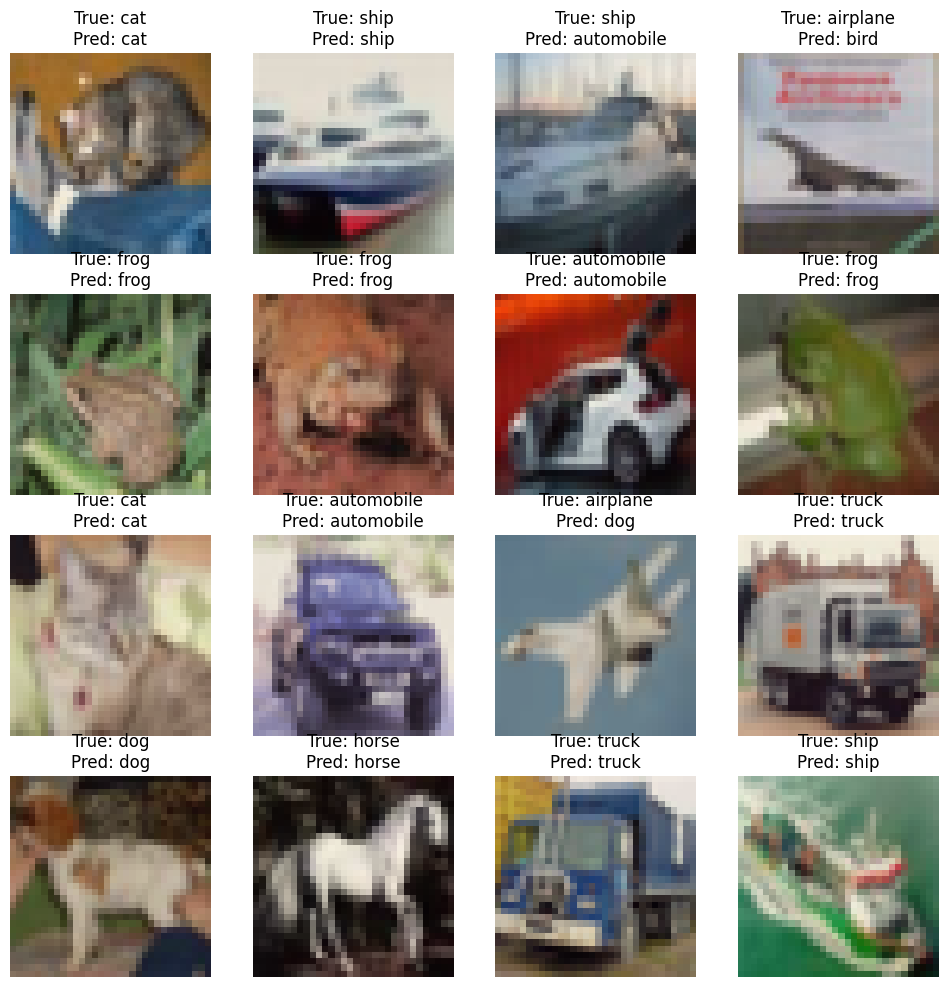

In [29]:

def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 12))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return


visualize_classification(model, test_loader, test_dataset.classes, num_images=16)
plt.show()
